<a href="https://colab.research.google.com/github/dinuwanfernando/Fund_strategy/blob/main/Fund_strategy_V2_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import math
import seaborn as sns
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from math import sqrt
import matplotlib.pyplot as plt
!pip install prophet
from prophet import Prophet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Economic variables are importing from fed api
%pip install fredapi --upgrade
import fredapi as fd
from fredapi import Fred
fd = Fred(api_key='bfc7a7c95be707dd6172b886bc431b68')

In [ ]:
#Variables that are belive to be highly correlated to the GBPUSD
%pip install oandapyV20
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
from oandapyV20.contrib.requests import MarketOrderRequest
access_token = "25828916746768cb5cf6f0ec2b97218e-0b9185adf70ecd8cf1b53bb781a4b1f3"
api = oandapyV20.API(access_token=access_token)

In [ ]:
#controlling the date peiod
date= '2024-02-29' # this is the date that is being used in for the economic variables (change end of each month, DONT CHANGE BEFORE THE END OF THE MONTH!!)
date_var= '2024-03-25' # this is the date that needs to change every week, this shoulud be till the saturday so the friday data will be included

In [ ]:
#model order for VAR models

#core =(6,1,8)
#fed =(2,7),3,5,4,4,1,1
#eur =(2,7),(6,7),(4,7),(1,2),(4,4)
#wti_close =(20,6) (2,6)
#wti_gbp = (8,6)

model_core= (6,1,8)
model_fed= (2,7)
model_eur= (4,4)
model_wti_close= (6,6)
model_gbp_volume= (8,6)



In [ ]:

#Variable 1 US Inflation rate
core_inflation_rate = fd.get_series('CPIAUCSL')

df_core= pd.DataFrame(core_inflation_rate, columns=['core_inflation']).sort_index(level=0)
df_core.index= pd.to_datetime(df_core.index)
df_core

,core_inflation
1947-01-01,21.480
1947-02-01,21.620
1947-03-01,22.000
1947-04-01,22.000
1947-05-01,21.950
...,...
2023-10-01,307.531
2023-11-01,308.024
2023-12-01,308.742
2024-01-01,309.685


In [ ]:
df_core_data= df_core[df_core.index< date].dropna()
print(df_core_data)

            core_inflation
1947-01-01          21.480
1947-02-01          21.620
1947-03-01          22.000
1947-04-01          22.000
1947-05-01          21.950
...                    ...
2023-10-01         307.531
2023-11-01         308.024
2023-12-01         308.742
2024-01-01         309.685
2024-02-01         311.054

[926 rows x 1 columns]


In [ ]:
#using ARIMA model to forecast Core_inflation

model_arima_core= ARIMA(df_core_data['core_inflation'], order = model_core)
results_arima_core= model_arima_core.fit()
print(results_arima_core.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         core_inflation   No. Observations:                  926
Model:                 ARIMA(6, 1, 8)   Log Likelihood                -360.217
Date:                Mon, 25 Mar 2024   AIC                            750.434
Time:                        06:11:54   BIC                            822.881
Sample:                    01-01-1947   HQIC                           778.073
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7400      0.161      4.606      0.000       0.425       1.055
ar.L2         -0.9028      0.274     -3.291      0.001      -1.440      -0.365
ar.L3          0.1353      0.405      0.334      0.7

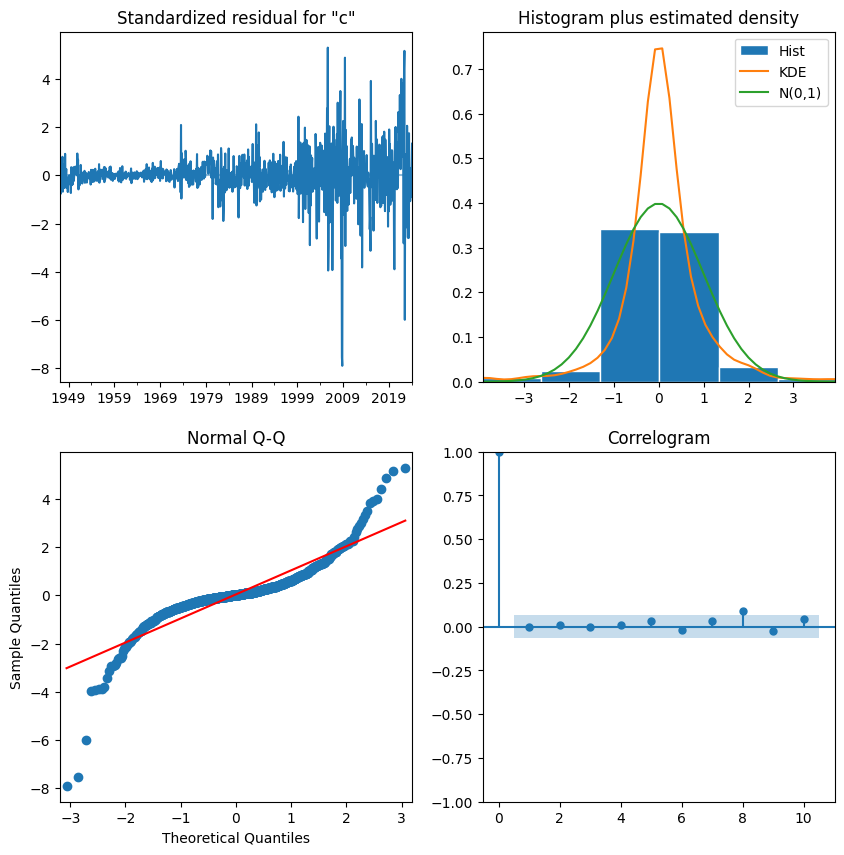

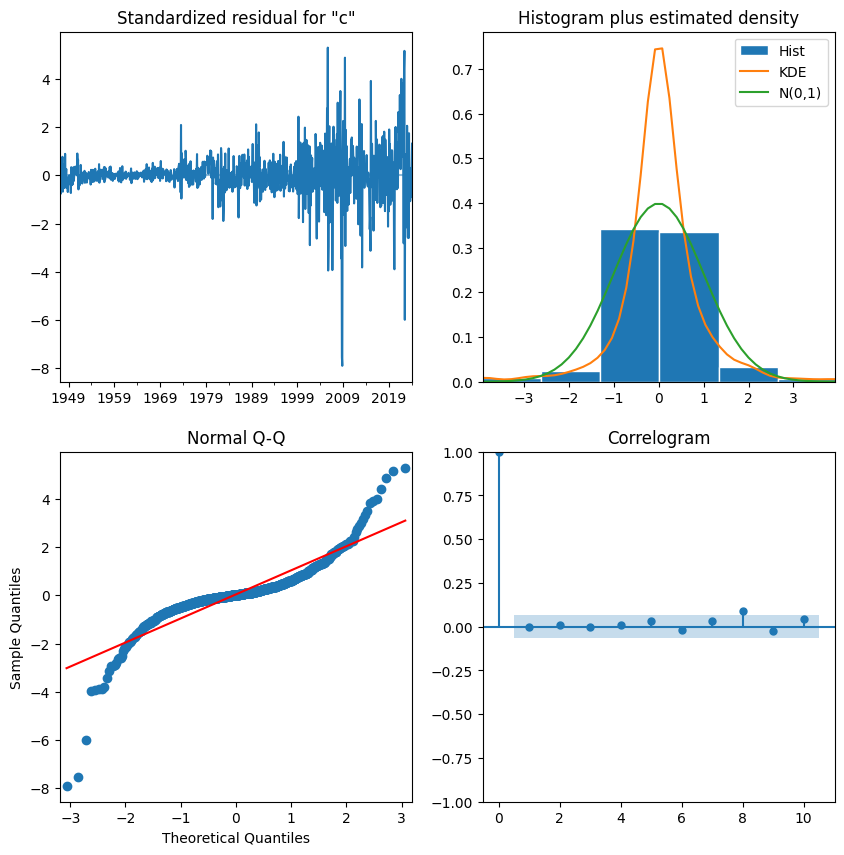

In [ ]:
#check the model fit for diagnostics

results_arima_core.plot_diagnostics(figsize=(10,10))

In [ ]:
#controlling the number of steps
future_arima= 3

In [ ]:
#forecasting for 3 months ahead
forecast_core= results_arima_core.get_forecast(steps=future_arima)
forecast_core_inflation = forecast_core.predicted_mean
forecast_core_inflation= pd.DataFrame(forecast_core_inflation)
forecast_core_inflation= forecast_core_inflation.rename(columns={'predicted_mean':'core_inflation'})
print(forecast_core_inflation)

            core_inflation
2024-03-01      312.493961
2024-04-01      313.705553
2024-05-01      314.447653


In [ ]:
#Variable 02 Fed fund rate
fed_rate = fd.get_series('DFF')

df_fed= pd.DataFrame(fed_rate, columns=['fed_rate']).sort_index(level=0)
df_fed.index= pd.to_datetime(df_fed.index)
df_fed

,fed_rate
1954-07-01,1.13
1954-07-02,1.25
1954-07-03,1.25
1954-07-04,1.25
1954-07-05,0.88
...,...
2024-03-17,5.33
2024-03-18,5.33
2024-03-19,5.33
2024-03-20,5.33


In [ ]:
df_fed_data= df_fed[df_fed.index< date].dropna()

In [ ]:
df_fed_VAR= pd.concat([df_fed_data,df_core_data],axis=1).dropna()
df_fed_VAR=df_fed_VAR[1:]
df_fed_VAR

,fed_rate,core_inflation
1954-08-01,0.25,26.850
1954-09-01,1.44,26.810
1954-10-01,0.50,26.720
1954-11-01,1.38,26.780
1954-12-01,1.25,26.770
...,...,...
2023-10-01,5.33,307.531
2023-11-01,5.33,308.024
2023-12-01,5.33,308.742
2024-01-01,5.33,309.685


In [ ]:
# Set ranges for p and q
#p_range_fed = range(1, 5)
#q_range_fed = range(0, 4)

# Initialize variables
#best_order_fed = None
#best_model_fed= None
#best_criteria_fed = float('inf')

# Grid search over p and q values
#for p in p_range_fed:
#    for q in q_range_fed:
#        model_fed = VARMAX(df_fed_VAR, order=(p, q),enforce_stationarity=True)
#        result_fed = model_fed.fit(disp=False)

        # Calculate information criteria
#        aic_value_fed = result_fed.aic
#        bic_value_fed= result_fed.bic
#        hqic_value_fed = result_fed.hqic

        # Find the best model based on the lowest criteria value
 #       if min(aic_value_fed, bic_value_fed, hqic_value_fed) < best_criteria_fed:
#            best_order_fed = (p, q)
#            best_model_fed = model_eur
 #           best_criteria_fed = min(aic_value_fed, bic_value_fed, hqic_value_fed)

# Print the best order and model
#print(f"Best order_eur (p, q): {best_order_fed}")
#print(best_model_fed)

In [ ]:
#VAR model for fed #3,5

model_var_fed= VARMAX(df_fed_VAR, order=(2,7), enforce_stationarity=True)
results_var_fed= model_var_fed.fit()
print(results_var_fed.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                 Statespace Model Results                                 
Dep. Variable:     ['fed_rate', 'core_inflation']   No. Observations:                  835
Model:                                 VARMA(2,7)   Log Likelihood               -4081.093
                                      + intercept   AIC                           8244.187
Date:                            Mon, 25 Mar 2024   BIC                           8438.011
Time:                                    06:13:03   HQIC                          8318.494
Sample:                                08-01-1954                                         
                                     - 02-01-2024                                         
Covariance Type:                              opg                                         
Ljung-Box (L1) (Q):         123.85, 404.54   Jarque-Bera (JB):      1231.54, 362.54
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedast

fed_rate          1.017992
core_inflation    5.458813
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


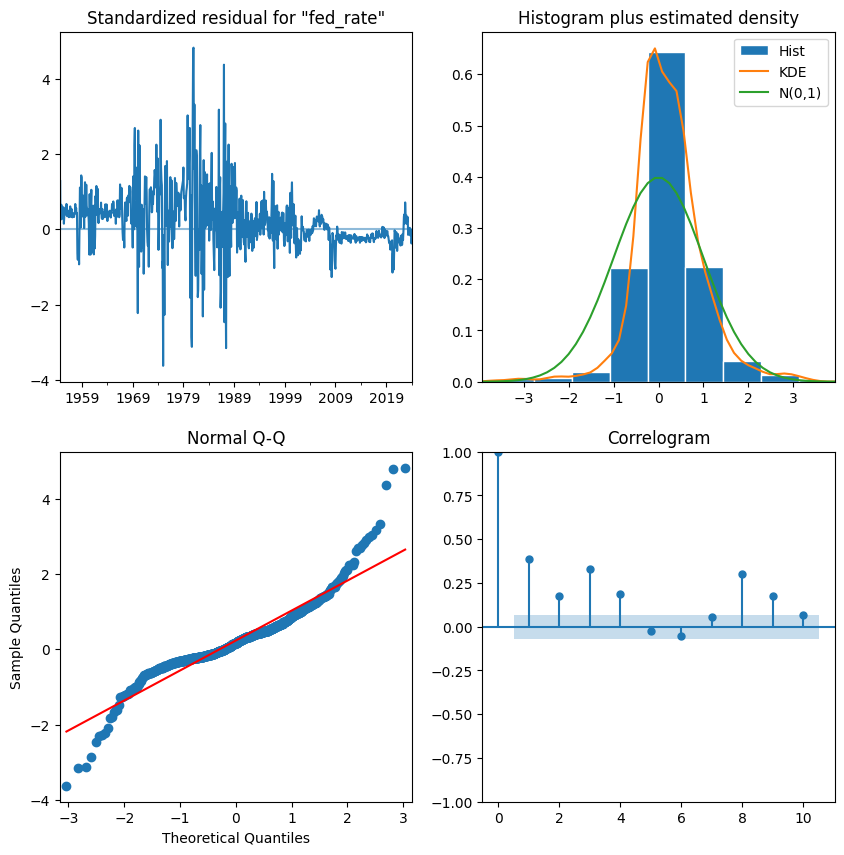

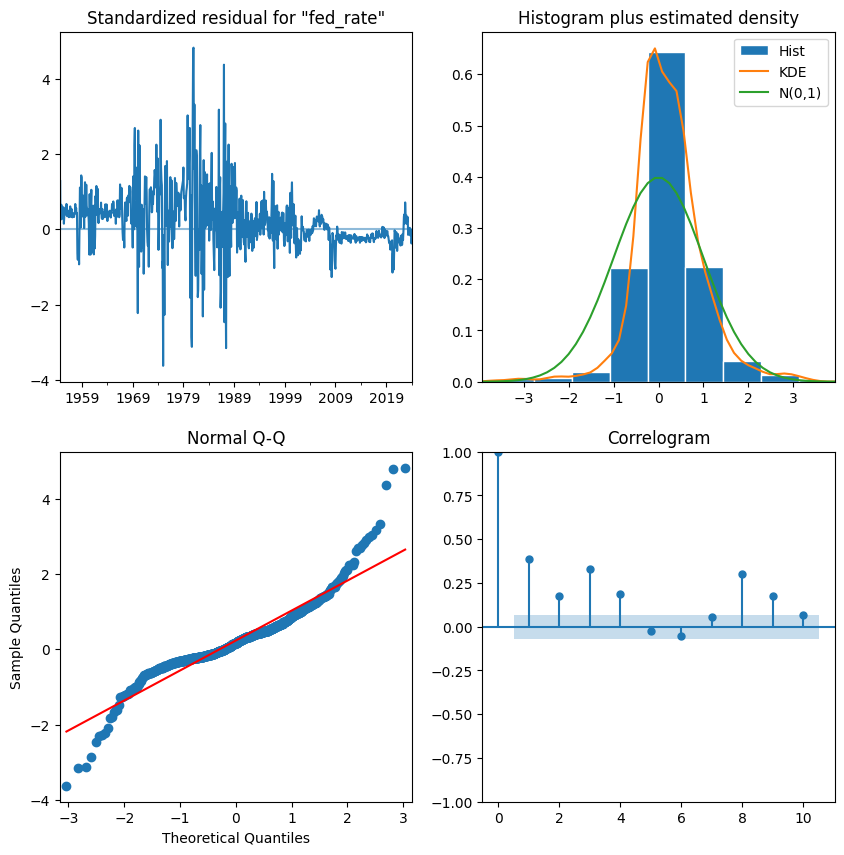

In [ ]:
mae_fed_var=np.mean(np.abs(results_var_fed.resid))
print(mae_fed_var)
results_var_fed.plot_diagnostics(figsize=(10,10))

In [ ]:
#controlling the forecast horizone
future_var_fed= 3

In [ ]:
#forecasting for 3 months ahead
forecast_fed= results_var_fed.get_forecast(steps=future_var_fed)
forecast_fed_rate = forecast_fed.predicted_mean
forecast_fed_rate = forecast_fed_rate['fed_rate']
forecast_fed_rate= pd.DataFrame(forecast_fed_rate)
#forecast_fed_rate= forecast_fed_rate.rename(columns={'predicted_mean':'fed_rate'})
print(forecast_fed_rate)

            fed_rate
2024-03-01  5.615106
2024-04-01  6.211357
2024-05-01  7.337979


In [ ]:
#variable non farm
#Variable 1 US Inflation rate
non_farm = fd.get_series('PAYEMS')

df_non_farm= pd.DataFrame(non_farm, columns=['non_farm']).sort_index(level=0)
df_non_farm.index= pd.to_datetime(df_non_farm.index)
df_non_farm

,non_farm
1939-01-01,29923.0
1939-02-01,30100.0
1939-03-01,30280.0
1939-04-01,30094.0
1939-05-01,30299.0
...,...
2023-10-01,156832.0
2023-11-01,157014.0
2023-12-01,157304.0
2024-01-01,157533.0


In [ ]:
df_non_farm_data= df_non_farm[df_non_farm.index< date].dropna()
df_non_farm_data

,non_farm
1939-01-01,29923.0
1939-02-01,30100.0
1939-03-01,30280.0
1939-04-01,30094.0
1939-05-01,30299.0
...,...
2023-10-01,156832.0
2023-11-01,157014.0
2023-12-01,157304.0
2024-01-01,157533.0


In [ ]:
#need to change the axis names to suit the prophet models requirment ds and y
df_non_farm_prophet_train= df_non_farm_data
df_non_farm_prophet_train=df_non_farm_prophet_train.rename_axis('ds')
df_non_farm_prophet_train.rename(columns={'non_farm':'y'},inplace=True)

print(df_non_farm_prophet_train)

                   y
ds                  
1939-01-01   29923.0
1939-02-01   30100.0
1939-03-01   30280.0
1939-04-01   30094.0
1939-05-01   30299.0
...              ...
2023-10-01  156832.0
2023-11-01  157014.0
2023-12-01  157304.0
2024-01-01  157533.0
2024-02-01  157808.0

[1022 rows x 1 columns]


In [ ]:
df_non_farm_prophet=df_non_farm_prophet_train.reset_index()
df_non_farm_prophet

,ds,y
0,1939-01-01,29923.0
1,1939-02-01,30100.0
2,1939-03-01,30280.0
3,1939-04-01,30094.0
4,1939-05-01,30299.0
...,...,...
1017,2023-10-01,156832.0
1018,2023-11-01,157014.0
1019,2023-12-01,157304.0
1020,2024-01-01,157533.0


In [ ]:
#future period
days= 120

In [ ]:
#prophet model
model_prophet_non = Prophet(growth='linear'

)
model_prophet_non.fit(df_non_farm_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo95pt0u8/zvuokgy8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo95pt0u8/94vsybp9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38666', 'data', 'file=/tmp/tmpo95pt0u8/zvuokgy8.json', 'init=/tmp/tmpo95pt0u8/94vsybp9.json', 'output', 'file=/tmp/tmpo95pt0u8/prophet_model5drf_dlo/prophet_model-20240325061306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:13:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:13:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#creating new days that we required predicted for

future_dates= model_prophet_non.make_future_dataframe(periods=120)
prediction_prophet_non_farm= model_prophet_non.predict(future_dates)
print(prediction_prophet_non_farm)

             ds          trend     yhat_lower     yhat_upper    trend_lower  \
0    1939-01-01   31569.806016   28427.250146   34576.302518   31569.806016   
1    1939-02-01   31730.338295   28629.767297   34978.771178   31730.338295   
2    1939-03-01   31875.335192   28688.574941   34456.998113   31875.335192   
3    1939-04-01   32035.867471   28631.784845   34956.470704   32035.867471   
4    1939-05-01   32191.221289   29078.106599   35213.467375   32191.221289   
...         ...            ...            ...            ...            ...   
1137 2024-05-27  152871.008788  149719.711513  156069.865573  152871.008788   
1138 2024-05-28  152874.279976  149935.120940  156056.455442  152874.279976   
1139 2024-05-29  152877.551163  149753.587346  155999.110163  152877.551163   
1140 2024-05-30  152880.822351  149484.786033  155964.467586  152880.822351   
1141 2024-05-31  152884.093538  149605.346244  156077.508975  152884.093538   

        trend_upper  additive_terms  additive_terms

In [ ]:
#extracting the data from the Fb prophet for fed rate

forecast_non_farm_prophet= prediction_prophet_non_farm[['ds','yhat']].tail(days)
forecast_non_farm_prophet.rename(columns={'yhat':'non_farm','ds':'Date'},inplace= True)
forecast_non_farm_prophet.set_index('Date',inplace=True)
forecast_non_farm_prophet=forecast_non_farm_prophet.asfreq('MS')
print(forecast_non_farm_prophet)

                 non_farm
Date                     
2024-03-01  152916.076517
2024-04-01  152306.854652
2024-05-01  152497.922696


In [ ]:
#bring all the forecasted economicn data set into a one datatframe

forecasted_eco_variables = pd.concat([forecast_core_inflation,forecast_fed_rate,forecast_non_farm_prophet ], axis=1)
forecasted_eco_variables

,core_inflation,fed_rate,non_farm
2024-03-01,312.493961,5.615106,152916.076517
2024-04-01,313.705553,6.211357,152306.854652
2024-05-01,314.447653,7.337979,152497.922696


In [ ]:
#variable eurusd

instrument = "EUR_USD"
params = {
    'count': 5000,  # Number of candles
    'granularity': 'D',  # Daily data #H1 and D
}

request = instruments.InstrumentsCandles(instrument=instrument, params=params)
response = api.request(request)

candle_data= response['candles']

df= pd.DataFrame(candle_data)
df= df[['time','mid','volume']]
df['date']= pd.to_datetime(df['time'])
df.set_index('date', inplace=True)
df.index= df.index.date # remove the time from the imported data
df_eurusd = pd.concat([df.drop(['mid'], axis=1), df['mid'].apply(pd.Series)], axis=1)
df_eurusd.rename(columns={'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close'}, inplace=True)
df_eurusd.rename(columns={'volume':'eur_volume','close':'eur_close'},inplace=True)

In [ ]:
df_eurusd=df_eurusd[['eur_close','eur_volume']]
print(df_eurusd)
df_eurusd.dtypes

           eur_close  eur_volume
2006-12-03   1.33416       18815
2006-12-04   1.33160       19369
2006-12-05   1.32872       18881
2006-12-06   1.32866       18033
2006-12-07   1.32025       30687
...              ...         ...
2024-03-18   1.08661       69751
2024-03-19   1.09220       76894
2024-03-20   1.08598       81777
2024-03-21   1.08077       60882
2024-03-24   1.08184       15074

[5000 rows x 2 columns]


eur_close     object
eur_volume     int64
dtype: object

In [ ]:
df_eur_data=df_eurusd.reset_index()

In [ ]:
df_eur_data['index']= pd.to_datetime(df_eur_data['index'])
df_eur_data.set_index('index',inplace=True)
df_eur_data

,eur_close,eur_volume
index,,
2006-12-03,1.33416,18815
2006-12-04,1.33160,19369
2006-12-05,1.32872,18881
2006-12-06,1.32866,18033
2006-12-07,1.32025,30687
...,...,...
2024-03-18,1.08661,69751
2024-03-19,1.09220,76894
2024-03-20,1.08598,81777


In [ ]:
training_data_var_eur=df_eur_data.astype(float)
training_data_var_eur.dtypes

eur_close     float64
eur_volume    float64
dtype: object

In [ ]:
df_eur_data= training_data_var_eur[training_data_var_eur.index< date_var].dropna()
df_eur_data

,eur_close,eur_volume
index,,
2006-12-03,1.33416,18815.0
2006-12-04,1.33160,19369.0
2006-12-05,1.32872,18881.0
2006-12-06,1.32866,18033.0
2006-12-07,1.32025,30687.0
...,...,...
2024-03-18,1.08661,69751.0
2024-03-19,1.09220,76894.0
2024-03-20,1.08598,81777.0


In [ ]:
df_eur_data= df_eur_data.rename_axis('Date')
df_eur_datav2 = df_eur_data#.asfreq('B').dropna()
df_eur_datav2

,eur_close,eur_volume
Date,,
2006-12-03,1.33416,18815.0
2006-12-04,1.33160,19369.0
2006-12-05,1.32872,18881.0
2006-12-06,1.32866,18033.0
2006-12-07,1.32025,30687.0
...,...,...
2024-03-18,1.08661,69751.0
2024-03-19,1.09220,76894.0
2024-03-20,1.08598,81777.0


In [ ]:
df_eur_datav2= df_eur_datav2[1:]
df_eur_datav2

,eur_close,eur_volume
Date,,
2006-12-04,1.33160,19369.0
2006-12-05,1.32872,18881.0
2006-12-06,1.32866,18033.0
2006-12-07,1.32025,30687.0
2006-12-09,1.31805,1231.0
...,...,...
2024-03-18,1.08661,69751.0
2024-03-19,1.09220,76894.0
2024-03-20,1.08598,81777.0


In [ ]:
# Set ranges for p and q
#p_range_eur = range(1, 5)
#q_range_eur = range(0, 5)

# Initialize variables
#best_order_eur = None
#best_model_eur = None
#best_criteria_eur = float('inf')

# Grid search over p and q values
#for p in p_range_eur:
#    for q in q_range_eur:
#        model_eur = VARMAX(df_eur_datav2, order=(p, q))
#        result_eur = model_eur.fit(disp=False)

        # Calculate information criteria
#        aic_value_eur = result_eur.aic
#        bic_value_eur = result_eur.bic
#        hqic_value_eur = result_eur.hqic

        # Find the best model based on the lowest criteria value
#        if min(aic_value_eur, bic_value_eur, hqic_value_eur) < best_criteria_eur:
#            best_order_eur = (p, q)
#            best_model_eur = model_eur
#            best_criteria_eur = min(aic_value_eur, bic_value_eur, hqic_value_eur)

# Print the best order and model
#print(f"Best order_eur (p, q): {best_order_eur}")
#print(best_model_eur)

In [ ]:
#modelling the data using VAR model # 2,7
model_var_eur_close=VARMAX(df_eur_datav2, order= (4,4), enforce_stationarity=True)
results_var_eur_close= model_var_eur_close.fit()
print(results_var_eur_close.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.48519e-25): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.84827e-19): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likeliho

                                Statespace Model Results                               
Dep. Variable:     ['eur_close', 'eur_volume']   No. Observations:                 4999
Model:                              VARMA(4,4)   Log Likelihood              -39512.042
                                   + intercept   AIC                          79098.084
Date:                         Mon, 25 Mar 2024   BIC                          79339.212
Time:                                 06:16:43   HQIC                         79182.596
Sample:                                      0                                         
                                        - 4999                                         
Covariance Type:                           opg                                         
Ljung-Box (L1) (Q):             0.03, 8.11   Jarque-Bera (JB):    2099.82, 16444.93
Prob(Q):                        0.86, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.34, 0.

eur_close         0.004827
eur_volume    15546.624680
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


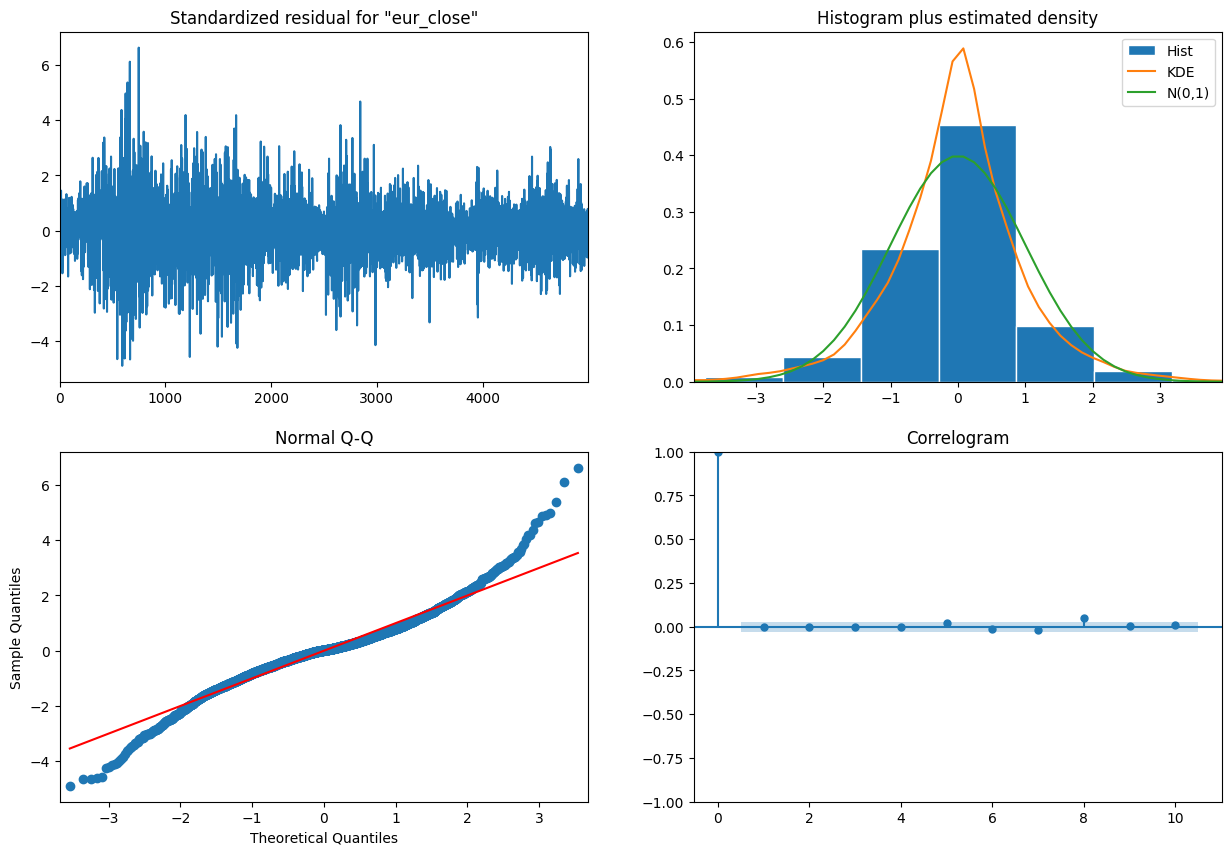

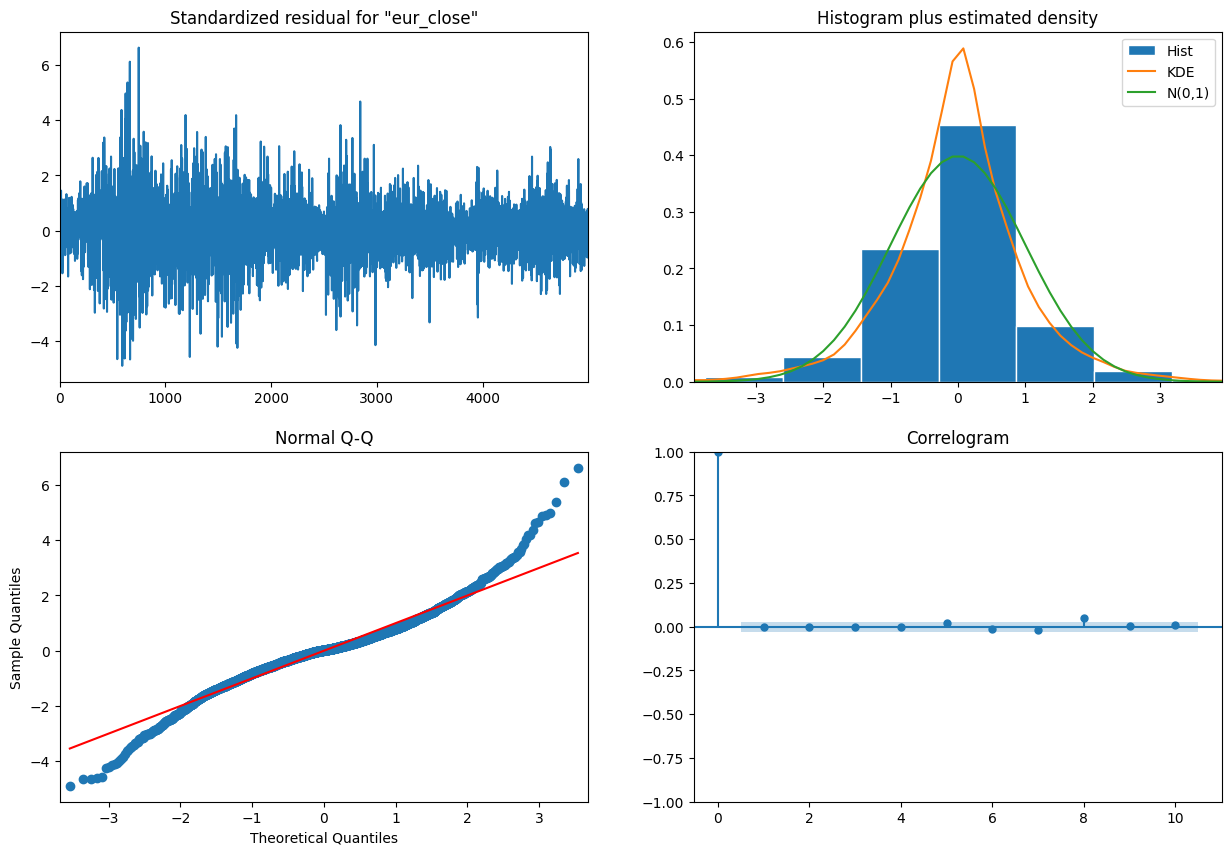

In [ ]:
mae_var_eur_close=np.mean(np.abs(results_var_eur_close.resid))
print(mae_var_eur_close)
results_var_eur_close.plot_diagnostics(figsize=(15,10))

In [ ]:
#future controller
future_var= 14
start_date= date_var
num_period= future_var

In [ ]:
#generate dates to use as index
date_range= pd.date_range(start=start_date, periods= num_period)
index= pd.DataFrame(date_range)
index=index.rename(columns={0:'Date'})
#index.asfreq('B')

In [ ]:
#out of sample
forecast_var_eur_close= results_var_eur_close.get_forecast(steps=future_var)
mean_forecast_out_var_eur_close= forecast_var_eur_close.predicted_mean
mean_out_eur_close= mean_forecast_out_var_eur_close[['eur_close','eur_volume']]
mean_out_eur_close = pd.DataFrame(mean_out_eur_close)
print(mean_out_eur_close)

      eur_close    eur_volume
4999   1.082085  45897.308626
5000   1.082459  56931.621378
5001   1.082776  59506.411861
5002   1.083205  59261.106321
5003   1.083493  57617.237597
5004   1.083708  59341.130856
5005   1.083913  60670.007629
5006   1.084132  61236.351976
5007   1.084359  61457.112534
5008   1.084576  62117.806568
5009   1.084786  62817.631049
5010   1.084994  63364.878605
5011   1.085202  63811.413339
5012   1.085407  64293.611405


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
eur_close_pred= mean_out_eur_close.reset_index()
eur_close_pred= eur_close_pred.drop(columns='index')
eur_close_pred

,eur_close,eur_volume
0,1.082085,45897.308626
1,1.082459,56931.621378
2,1.082776,59506.411861
3,1.083205,59261.106321
4,1.083493,57617.237597
5,1.083708,59341.130856
6,1.083913,60670.007629
7,1.084132,61236.351976
8,1.084359,61457.112534
9,1.084576,62117.806568


In [ ]:
eur_close_pred_v2= pd.concat([index, eur_close_pred], axis=1)
eur_close_pred_v2

,Date,eur_close,eur_volume
0,2024-03-25,1.082085,45897.308626
1,2024-03-26,1.082459,56931.621378
2,2024-03-27,1.082776,59506.411861
3,2024-03-28,1.083205,59261.106321
4,2024-03-29,1.083493,57617.237597
5,2024-03-30,1.083708,59341.130856
6,2024-03-31,1.083913,60670.007629
7,2024-04-01,1.084132,61236.351976
8,2024-04-02,1.084359,61457.112534
9,2024-04-03,1.084576,62117.806568


In [ ]:
eur_close_pred_v2['Date']= pd.to_datetime(eur_close_pred_v2['Date'])
eur_close_pred_v2.set_index('Date', inplace=True)
eur_close_pred_v2

,eur_close,eur_volume
Date,,
2024-03-25,1.082085,45897.308626
2024-03-26,1.082459,56931.621378
2024-03-27,1.082776,59506.411861
2024-03-28,1.083205,59261.106321
2024-03-29,1.083493,57617.237597
2024-03-30,1.083708,59341.130856
2024-03-31,1.083913,60670.007629
2024-04-01,1.084132,61236.351976
2024-04-02,1.084359,61457.112534


In [ ]:
#variable 06 WTI crude oil data

instrument = "WTICO_USD"
params = {
    'count': 5000,  # Number of candles
    'granularity': 'D',  # Daily data #H1 and D
}

request = instruments.InstrumentsCandles(instrument=instrument, params=params)
response = api.request(request)

candle_data= response['candles']

df_wti= pd.DataFrame(candle_data)
df_wti= df_wti[['time','mid','volume']]
df_wti['date']= pd.to_datetime(df_wti['time'])
df_wti.set_index('date', inplace=True)
df_wti.index= df_wti.index.date # remove the time from the imported data
df_wti = pd.concat([df_wti.drop(['mid'], axis=1), df_wti['mid'].apply(pd.Series)], axis=1)
df_wti.rename(columns={'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close'}, inplace=True)
df_wti.rename(columns={'volume':'wti_volume','close':'wti_close'},inplace=True)

In [ ]:
df_wti=df_wti[['wti_volume','wti_close']]
print(df_wti)
df_wti.dtypes

            wti_volume wti_close
2006-02-26        2445    59.435
2006-02-27        2138    60.503
2006-02-28        2310    60.721
2006-03-01        2115    62.381
2006-03-02        2082    62.457
...                ...       ...
2024-03-18       39816    82.934
2024-03-19       48558    81.831
2024-03-20       41559    81.185
2024-03-21       37047    81.173
2024-03-24        3836    81.395

[5000 rows x 2 columns]


wti_volume     int64
wti_close     object
dtype: object

In [ ]:
df_wti_data=df_wti.reset_index()

In [ ]:
df_wti_data['index']= pd.to_datetime(df_wti_data['index'])
df_wti_data.set_index('index',inplace=True)
df_wti_data

,wti_volume,wti_close
index,,
2006-02-26,2445,59.435
2006-02-27,2138,60.503
2006-02-28,2310,60.721
2006-03-01,2115,62.381
2006-03-02,2082,62.457
...,...,...
2024-03-18,39816,82.934
2024-03-19,48558,81.831
2024-03-20,41559,81.185


In [ ]:
training_data_var_wti=df_wti_data.astype(float)
training_data_var_wti.dtypes

wti_volume    float64
wti_close     float64
dtype: object

In [ ]:
df_wti_data= training_data_var_wti[training_data_var_wti.index< date_var].dropna()
df_wti_data

,wti_volume,wti_close
index,,
2006-02-26,2445.0,59.435
2006-02-27,2138.0,60.503
2006-02-28,2310.0,60.721
2006-03-01,2115.0,62.381
2006-03-02,2082.0,62.457
...,...,...
2024-03-18,39816.0,82.934
2024-03-19,48558.0,81.831
2024-03-20,41559.0,81.185


In [ ]:
df_wti_data= df_wti_data.rename_axis('Date')
df_wti_data

,wti_volume,wti_close
Date,,
2006-02-26,2445.0,59.435
2006-02-27,2138.0,60.503
2006-02-28,2310.0,60.721
2006-03-01,2115.0,62.381
2006-03-02,2082.0,62.457
...,...,...
2024-03-18,39816.0,82.934
2024-03-19,48558.0,81.831
2024-03-20,41559.0,81.185


In [ ]:
df_wti_data= df_wti_data[1:]
df_wti_data

,wti_volume,wti_close
Date,,
2006-02-27,2138.0,60.503
2006-02-28,2310.0,60.721
2006-03-01,2115.0,62.381
2006-03-02,2082.0,62.457
2006-03-05,2403.0,61.301
...,...,...
2024-03-18,39816.0,82.934
2024-03-19,48558.0,81.831
2024-03-20,41559.0,81.185


In [ ]:
# Set ranges for p and q
#p_range = range(1, 7)
#q_range = range(0, 7)

# Initialize variables
#best_order = None
#best_model = None
#best_criteria = float('inf')

# Grid search over p and q values
#for p in p_range:
#    for q in q_range:
#        model_test_fed = VARMAX(df_wti_data, order=(p, q))
#        result_fed = model_test_fed.fit(disp=False)

        # Calculate information criteria
 #       aic_value = result_fed.aic
 #       bic_value = result_fed.bic
 #       hqic_value = result_fed.hqic

        # Find the best model based on the lowest criteria value
  #      if min(aic_value, bic_value, hqic_value) < best_criteria:
   #         best_order = (p, q)
    #        best_model = model_test_fed
     #       best_criteria = min(aic_value, bic_value, hqic_value)

# Print the best order and model
#print(f"Best order (p, q): {best_order}")
#print(best_model)

In [ ]:
#modelling the data using VAR model
model_var_wti_close=VARMAX(df_wti_data, order=(6,6), enforce_stationarity=True)
results_var_wti_close= model_var_wti_close.fit()
print(results_var_wti_close.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                Statespace Model Results                               
Dep. Variable:     ['wti_volume', 'wti_close']   No. Observations:                 4999
Model:                              VARMA(6,6)   Log Likelihood              -66410.771
                                   + intercept   AIC                         132927.543
Date:                         Mon, 25 Mar 2024   BIC                         133272.943
Time:                                 06:22:07   HQIC                        133048.601
Sample:                                      0                                         
                                        - 4999                                         
Covariance Type:                           opg                                         
Ljung-Box (L1) (Q):             0.10, 0.02   Jarque-Bera (JB):   450721.58, 7412.54
Prob(Q):                        0.75, 0.88   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         3.70, 1.

wti_volume    13366.546154
wti_close         1.079890
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


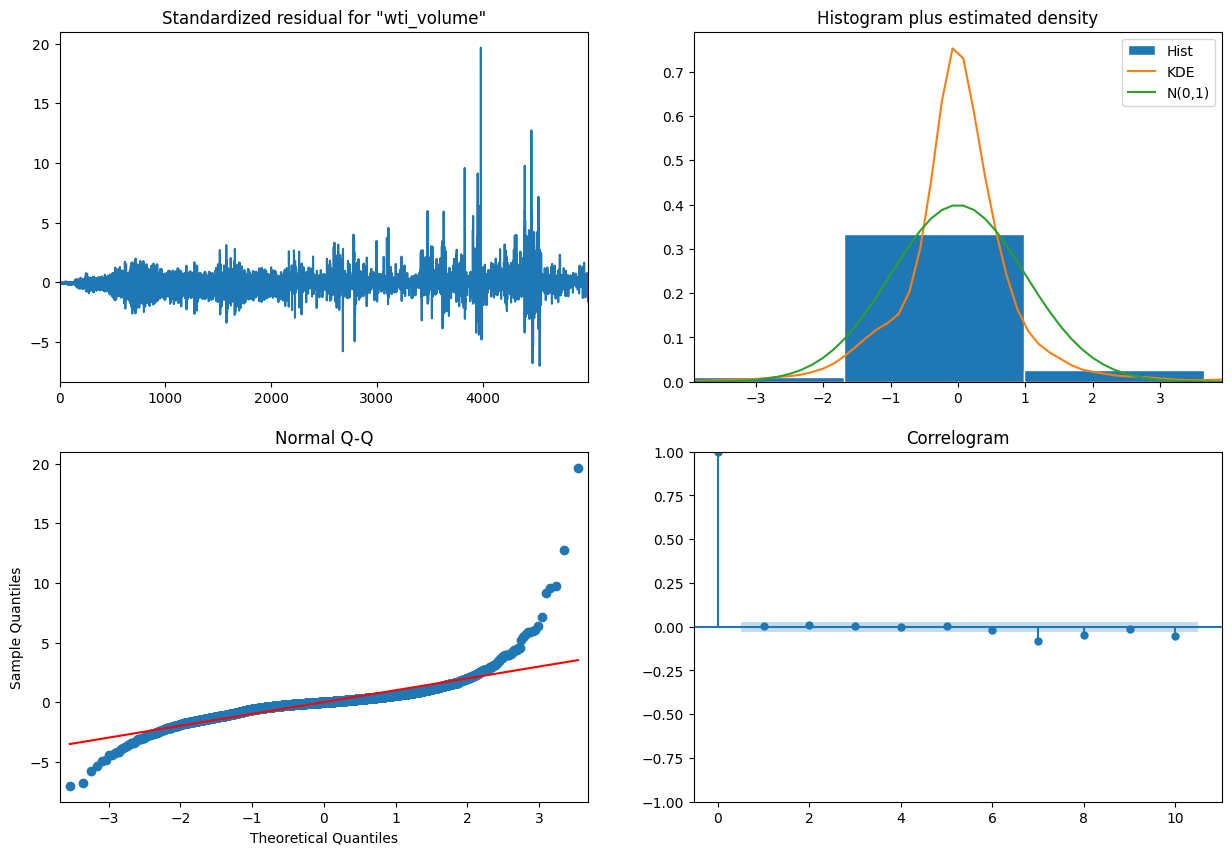

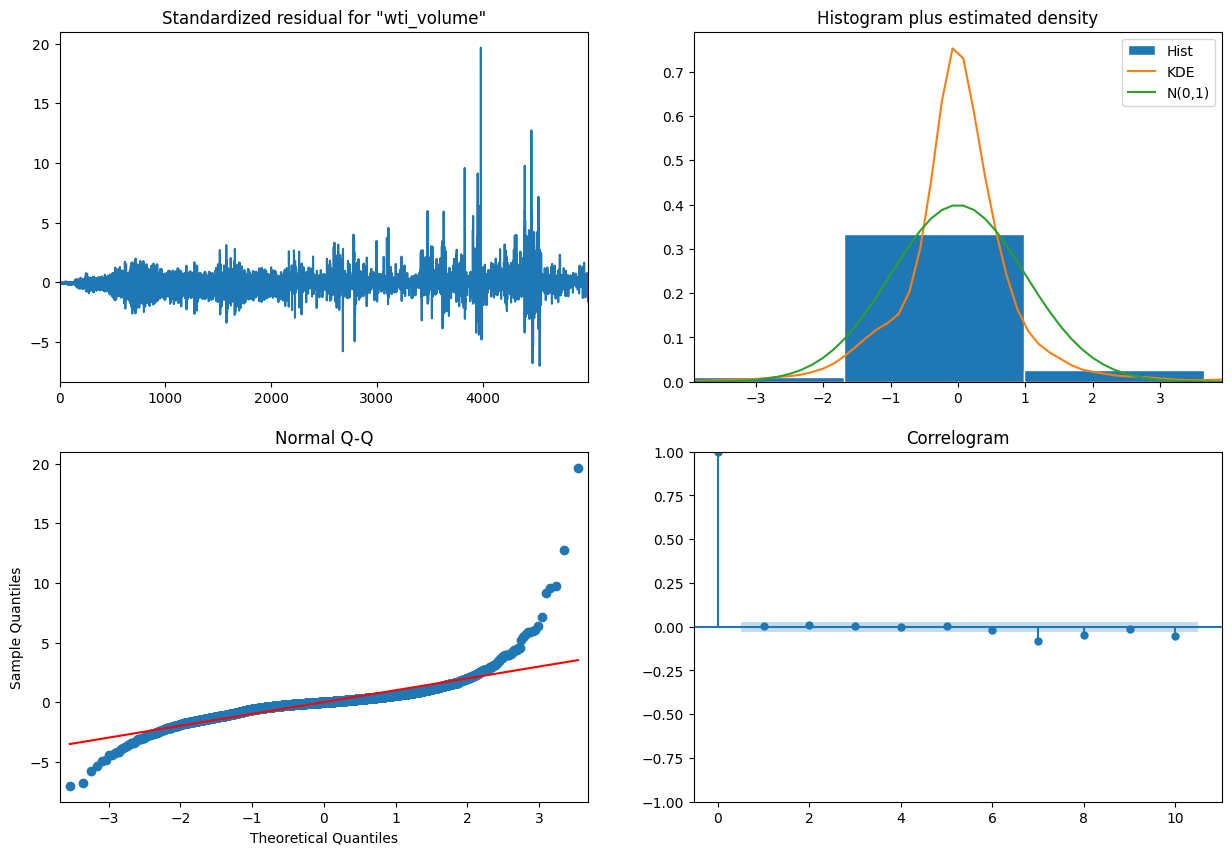

In [ ]:
mae_var_wti_close=np.mean(np.abs(results_var_wti_close.resid))
print(mae_var_wti_close)
results_var_wti_close.plot_diagnostics(figsize=(15,10))

In [ ]:
#out of sample
forecast_var_wti_close= results_var_wti_close.get_forecast(steps=future_var)
mean_forecast_out_var_wti_close= forecast_var_wti_close.predicted_mean
mean_out_wti_close= mean_forecast_out_var_wti_close[['wti_close','wti_volume']]
mean_out_wti_close = pd.DataFrame(mean_out_wti_close)
print(mean_out_wti_close)

      wti_close    wti_volume
4999  81.236121  24927.533503
5000  81.121983  30341.111788
5001  81.103538  34009.467786
5002  81.127050  32966.241817
5003  81.169193  32978.090768
5004  81.215117  28571.864852
5005  81.227155  30797.659444
5006  81.191121  32367.909414
5007  81.162192  33272.774825
5008  81.121078  33122.654716
5009  81.095065  32854.101724
5010  81.090460  32724.906735
5011  81.073997  33312.548049
5012  81.047875  33845.226224


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
wti_close_pred= mean_out_wti_close.reset_index()
wti_close_pred= wti_close_pred.drop(columns='index')
wti_close_pred

,wti_close,wti_volume
0,81.236121,24927.533503
1,81.121983,30341.111788
2,81.103538,34009.467786
3,81.127050,32966.241817
4,81.169193,32978.090768
5,81.215117,28571.864852
6,81.227155,30797.659444
7,81.191121,32367.909414
8,81.162192,33272.774825
9,81.121078,33122.654716


In [ ]:
wti_close_pred_v2= pd.concat([index, wti_close_pred], axis=1)
wti_close_pred_v2

,Date,wti_close,wti_volume
0,2024-03-25,81.236121,24927.533503
1,2024-03-26,81.121983,30341.111788
2,2024-03-27,81.103538,34009.467786
3,2024-03-28,81.127050,32966.241817
4,2024-03-29,81.169193,32978.090768
5,2024-03-30,81.215117,28571.864852
6,2024-03-31,81.227155,30797.659444
7,2024-04-01,81.191121,32367.909414
8,2024-04-02,81.162192,33272.774825
9,2024-04-03,81.121078,33122.654716


In [ ]:
wti_close_pred_v2['Date']= pd.to_datetime(wti_close_pred_v2['Date'])
wti_close_pred_v2.set_index('Date', inplace=True)
wti_close_pred_v2

,wti_close,wti_volume
Date,,
2024-03-25,81.236121,24927.533503
2024-03-26,81.121983,30341.111788
2024-03-27,81.103538,34009.467786
2024-03-28,81.127050,32966.241817
2024-03-29,81.169193,32978.090768
2024-03-30,81.215117,28571.864852
2024-03-31,81.227155,30797.659444
2024-04-01,81.191121,32367.909414
2024-04-02,81.162192,33272.774825


In [ ]:
#variable GBPUSD volume data considered a independent variable

instrument = "GBP_USD"
params = {
    'count': 5000,  # Number of candles
    'granularity': 'D',  # Daily data #H1 and D
}

request = instruments.InstrumentsCandles(instrument=instrument, params=params)
response = api.request(request)

candle_data= response['candles']

df_gbp= pd.DataFrame(candle_data)
df_gbp= df_gbp[['time','mid','volume']]
df_gbp['date']= pd.to_datetime(df_gbp['time'])
df_gbp.set_index('date', inplace=True)
df_gbp.index= df_gbp.index.date # remove the time from the imported data
df_gbp = pd.concat([df_gbp.drop(['mid'], axis=1), df_gbp['mid'].apply(pd.Series)], axis=1)
df_gbp.rename(columns={'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close'}, inplace=True)
df_gbp.rename(columns={'volume':'gbp_volume','close':'gbp_close'},inplace=True)

In [ ]:
df_gbp=df_gbp[['gbp_volume','gbp_close']]
print(df_gbp)
df_gbp.dtypes

            gbp_volume gbp_close
2006-12-01           1   1.98105
2006-12-02         901   1.97650
2006-12-03       21868   1.98148
2006-12-04       23644   1.97330
2006-12-05       21739   1.96651
...                ...       ...
2024-03-18       92838   1.27218
2024-03-19      102668   1.27865
2024-03-20      109405   1.26575
2024-03-21       86527   1.26004
2024-03-24       23221   1.26097

[5000 rows x 2 columns]


gbp_volume     int64
gbp_close     object
dtype: object

In [ ]:
df_gbp_data=df_gbp.reset_index()

In [ ]:
df_gbp_data['index']= pd.to_datetime(df_gbp_data['index'])
df_gbp_data.set_index('index',inplace=True)
df_gbp_data

,gbp_volume,gbp_close
index,,
2006-12-01,1,1.98105
2006-12-02,901,1.97650
2006-12-03,21868,1.98148
2006-12-04,23644,1.97330
2006-12-05,21739,1.96651
...,...,...
2024-03-18,92838,1.27218
2024-03-19,102668,1.27865
2024-03-20,109405,1.26575


In [ ]:
training_data_var_gbp=df_gbp_data.astype(float)
training_data_var_gbp.dtypes

gbp_volume    float64
gbp_close     float64
dtype: object

In [ ]:
df_gbp_data= training_data_var_gbp[training_data_var_gbp.index< date_var].dropna()
df_gbp_data

,gbp_volume,gbp_close
index,,
2006-12-01,1.0,1.98105
2006-12-02,901.0,1.97650
2006-12-03,21868.0,1.98148
2006-12-04,23644.0,1.97330
2006-12-05,21739.0,1.96651
...,...,...
2024-03-18,92838.0,1.27218
2024-03-19,102668.0,1.27865
2024-03-20,109405.0,1.26575


In [ ]:
df_gbp_data= df_gbp_data.rename_axis('Date')
df_gbp_data

,gbp_volume,gbp_close
Date,,
2006-12-01,1.0,1.98105
2006-12-02,901.0,1.97650
2006-12-03,21868.0,1.98148
2006-12-04,23644.0,1.97330
2006-12-05,21739.0,1.96651
...,...,...
2024-03-18,92838.0,1.27218
2024-03-19,102668.0,1.27865
2024-03-20,109405.0,1.26575


In [ ]:
df_gbp_data= df_gbp_data[1:]
df_gbp_data

,gbp_volume,gbp_close
Date,,
2006-12-02,901.0,1.97650
2006-12-03,21868.0,1.98148
2006-12-04,23644.0,1.97330
2006-12-05,21739.0,1.96651
2006-12-06,21607.0,1.96306
...,...,...
2024-03-18,92838.0,1.27218
2024-03-19,102668.0,1.27865
2024-03-20,109405.0,1.26575


In [ ]:
#modelling the data using VAR model #(8,6)
model_var_gbp_close=VARMAX(df_gbp_data, order=(4,6), enforce_stationarity=True)
results_var_gbp_close= model_var_gbp_close.fit()
print(results_var_gbp_close.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.49485e-24): result may not be accurate.
  x = solve(lhs, q.flatten())


                                Statespace Model Results                               
Dep. Variable:     ['gbp_volume', 'gbp_close']   No. Observations:                 4999
Model:                              VARMA(4,6)   Log Likelihood              -47726.694
                                   + intercept   AIC                          95543.388
Date:                         Mon, 25 Mar 2024   BIC                          95836.653
Time:                                 06:28:12   HQIC                         95646.174
Sample:                                      0                                         
                                        - 4999                                         
Covariance Type:                           opg                                         
Ljung-Box (L1) (Q):          20.65, 730.36   Jarque-Bera (JB):   284456.72, 33154.30
Prob(Q):                        0.00, 0.00   Prob(JB):                    0.00, 0.00
Heteroskedasticity (H):         1.74, 

gbp_volume    16444.122924
gbp_close         0.017825
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


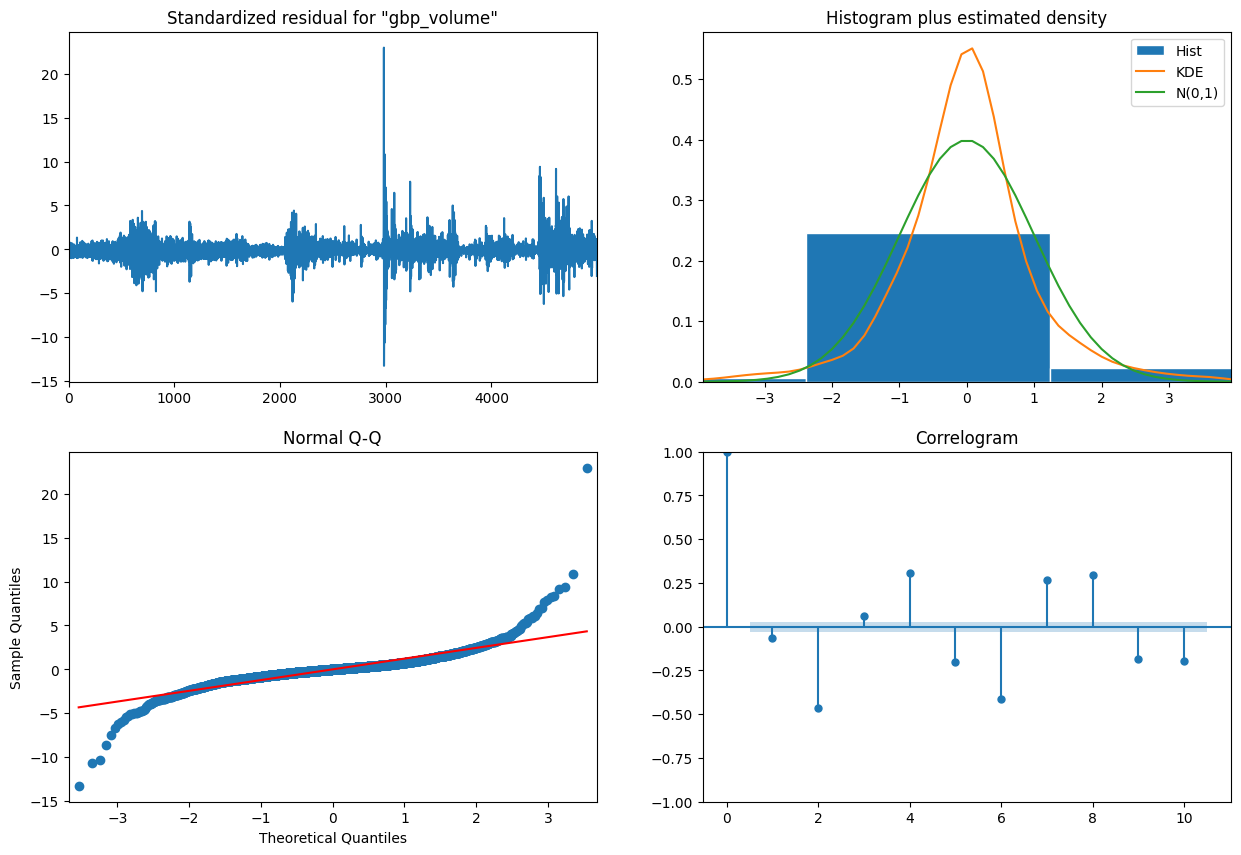

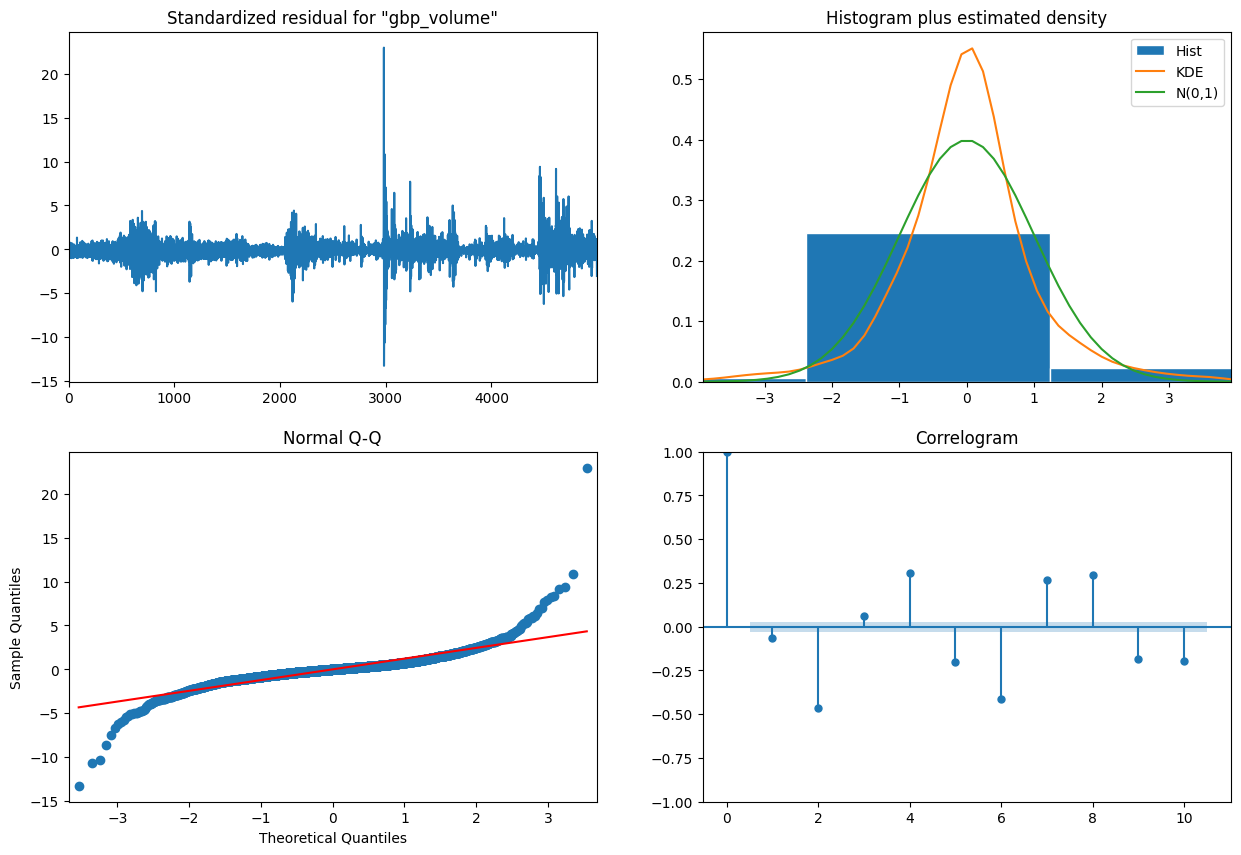

In [ ]:
mae_var_gbp_close=np.mean(np.abs(results_var_gbp_close.resid))
print(mae_var_gbp_close)
results_var_gbp_close.plot_diagnostics(figsize=(15,10))

In [ ]:
#out of sample
forecast_var_gbp_close= results_var_gbp_close.get_forecast(steps=future_var)
mean_forecast_out_var_gbp_close= forecast_var_gbp_close.predicted_mean
mean_out_gbp_close= mean_forecast_out_var_gbp_close['gbp_volume']
mean_out_gbp_close = pd.DataFrame(mean_out_gbp_close)
print(mean_out_gbp_close)

        gbp_volume
4999  37448.067528
5000  44402.144455
5001  56449.244725
5002  63785.143815
5003  45200.280564
5004  20224.844009
5005  35944.512797
5006  39691.751131
5007  39137.806657
5008  37846.071276
5009  38953.004968
5010  39745.375585
5011  40154.380750
5012  40432.519357


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
gbp_close_pred= mean_out_gbp_close.reset_index()
gbp_close_pred= gbp_close_pred.drop(columns='index')
gbp_close_pred

,gbp_volume
0,37448.067528
1,44402.144455
2,56449.244725
3,63785.143815
4,45200.280564
5,20224.844009
6,35944.512797
7,39691.751131
8,39137.806657
9,37846.071276


In [ ]:
gbp_close_pred_v2= pd.concat([index, gbp_close_pred], axis=1)
gbp_close_pred_v2

,Date,gbp_volume
0,2024-03-25,37448.067528
1,2024-03-26,44402.144455
2,2024-03-27,56449.244725
3,2024-03-28,63785.143815
4,2024-03-29,45200.280564
5,2024-03-30,20224.844009
6,2024-03-31,35944.512797
7,2024-04-01,39691.751131
8,2024-04-02,39137.806657
9,2024-04-03,37846.071276


In [ ]:
gbp_close_pred_v2['Date']= pd.to_datetime(gbp_close_pred_v2['Date'])
gbp_close_pred_v2.set_index('Date', inplace=True)
gbp_close_pred_v2

,gbp_volume
Date,
2024-03-25,37448.067528
2024-03-26,44402.144455
2024-03-27,56449.244725
2024-03-28,63785.143815
2024-03-29,45200.280564
2024-03-30,20224.844009
2024-03-31,35944.512797
2024-04-01,39691.751131
2024-04-02,39137.806657


In [ ]:
forecasted_eco_variables_2= forecasted_eco_variables.asfreq('D',method='ffill')
print(forecasted_eco_variables_2)

            core_inflation  fed_rate       non_farm
2024-03-01      312.493961  5.615106  152916.076517
2024-03-02      312.493961  5.615106  152916.076517
2024-03-03      312.493961  5.615106  152916.076517
2024-03-04      312.493961  5.615106  152916.076517
2024-03-05      312.493961  5.615106  152916.076517
...                    ...       ...            ...
2024-04-27      313.705553  6.211357  152306.854652
2024-04-28      313.705553  6.211357  152306.854652
2024-04-29      313.705553  6.211357  152306.854652
2024-04-30      313.705553  6.211357  152306.854652
2024-05-01      314.447653  7.337979  152497.922696

[62 rows x 3 columns]


In [ ]:
df1= pd.concat([gbp_close_pred_v2,wti_close_pred_v2,eur_close_pred_v2,forecasted_eco_variables_2], axis=1).dropna()
df1.dtypes
df1

,gbp_volume,wti_close,wti_volume,eur_close,eur_volume,core_inflation,fed_rate,non_farm
2024-03-25,37448.067528,81.236121,24927.533503,1.082085,45897.308626,312.493961,5.615106,152916.076517
2024-03-26,44402.144455,81.121983,30341.111788,1.082459,56931.621378,312.493961,5.615106,152916.076517
2024-03-27,56449.244725,81.103538,34009.467786,1.082776,59506.411861,312.493961,5.615106,152916.076517
2024-03-28,63785.143815,81.127050,32966.241817,1.083205,59261.106321,312.493961,5.615106,152916.076517
2024-03-29,45200.280564,81.169193,32978.090768,1.083493,57617.237597,312.493961,5.615106,152916.076517
2024-03-30,20224.844009,81.215117,28571.864852,1.083708,59341.130856,312.493961,5.615106,152916.076517
2024-03-31,35944.512797,81.227155,30797.659444,1.083913,60670.007629,312.493961,5.615106,152916.076517
2024-04-01,39691.751131,81.191121,32367.909414,1.084132,61236.351976,313.705553,6.211357,152306.854652
2024-04-02,39137.806657,81.162192,33272.774825,1.084359,61457.112534,313.705553,6.211357,152306.854652
2024-04-03,37846.071276,81.121078,33122.654716,1.084576,62117.806568,313.705553,6.211357,152306.854652


In [ ]:
df1 = df1.rename_axis('Date')

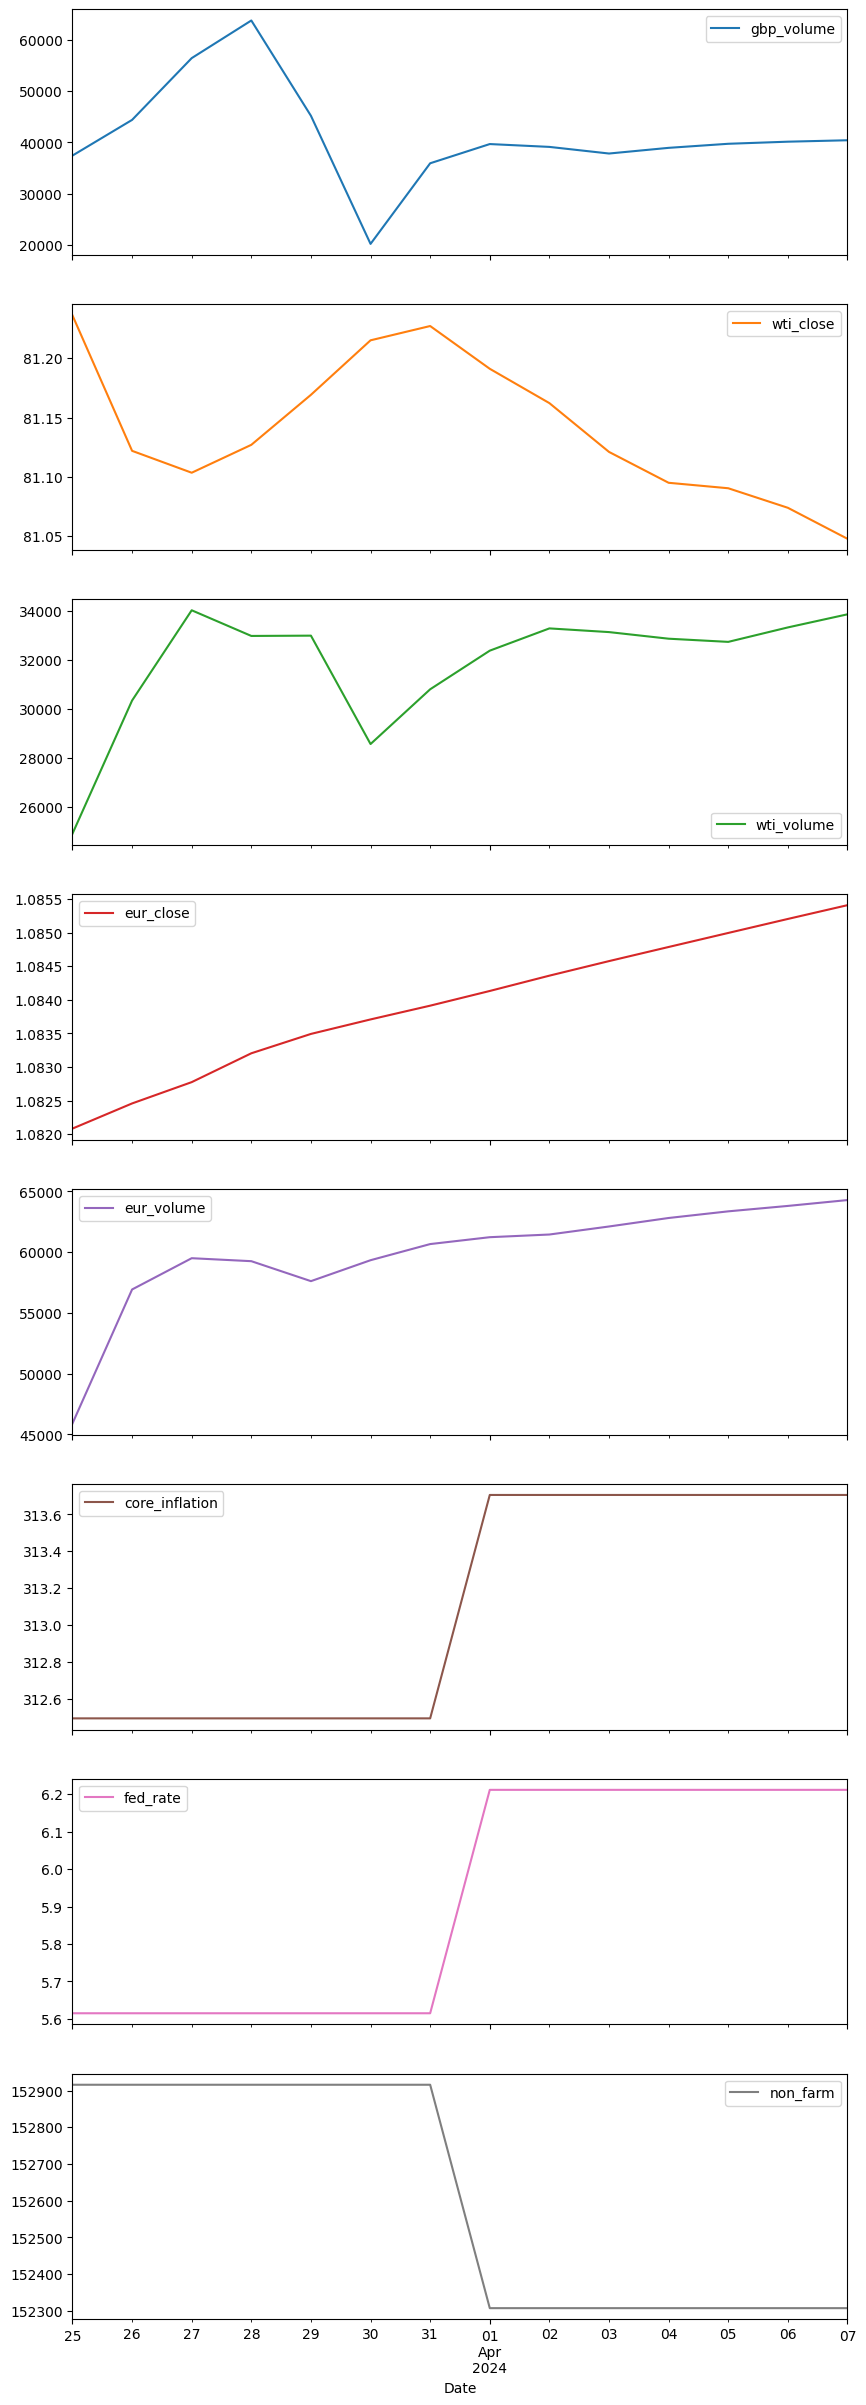

In [ ]:
#visulisation of the forecasted output for verification purpose before the using this data for the prediction

df1.plot(subplots=True,figsize=(10,30))
plt.show()

In [ ]:
#Any changes to the values should be changed and need to upload here for the generating the predictions
df1.to_csv('forecasted_data_v2.csv')

In [ ]:
#after editing this is where the importing of data happens
df2= pd.read_csv('forecasted_data_v2.csv', parse_dates=['Date'],index_col= 'Date')
df2

,gbp_volume,wti_close,wti_volume,eur_close,eur_volume,core_inflation,fed_rate,non_farm
Date,,,,,,,,
2024-03-25,37448.067528,81.236121,24927.533503,1.082085,45897.308626,312.493961,5.615106,152916.076517
2024-03-26,44402.144455,81.121983,30341.111788,1.082459,56931.621378,312.493961,5.615106,152916.076517
2024-03-27,56449.244725,81.103538,34009.467786,1.082776,59506.411861,312.493961,5.615106,152916.076517
2024-03-28,63785.143815,81.127050,32966.241817,1.083205,59261.106321,312.493961,5.615106,152916.076517
2024-03-29,45200.280564,81.169193,32978.090768,1.083493,57617.237597,312.493961,5.615106,152916.076517
2024-03-30,20224.844009,81.215117,28571.864852,1.083708,59341.130856,312.493961,5.615106,152916.076517
2024-03-31,35944.512797,81.227155,30797.659444,1.083913,60670.007629,312.493961,5.615106,152916.076517
2024-04-01,39691.751131,81.191121,32367.909414,1.084132,61236.351976,313.705553,6.211357,152306.854652
2024-04-02,39137.806657,81.162192,33272.774825,1.084359,61457.112534,313.705553,6.211357,152306.854652


In [ ]:
#creating the training dataset for the economic variables

df_econ= pd.concat([df_fed_VAR,df_non_farm], axis=1).dropna()
df_econ= pd.concat([df_econ,forecasted_eco_variables],axis=0)
df_econ= df_econ.asfreq('D',method='ffill').dropna()
df_econ

,fed_rate,core_inflation,non_farm
1954-08-01,0.250000,26.850000,48826.000000
1954-08-02,0.250000,26.850000,48826.000000
1954-08-03,0.250000,26.850000,48826.000000
1954-08-04,0.250000,26.850000,48826.000000
1954-08-05,0.250000,26.850000,48826.000000
...,...,...,...
2024-04-27,6.211357,313.705553,152306.854652
2024-04-28,6.211357,313.705553,152306.854652
2024-04-29,6.211357,313.705553,152306.854652
2024-04-30,6.211357,313.705553,152306.854652


In [ ]:
#Xgboost model training dataset
#need to train the xgboost model using this dataset
xgb_train_df= pd.concat([df_eur_data,df_wti_data,df_econ,df_gbp_data], axis=1).dropna()
xgb_train_df= xgb_train_df.asfreq('D').dropna()
xgb_train_df=xgb_train_df.rename_axis('Date')
xgb_train_df.to_csv('X_train_dataset_modelxgb.csv')

In [ ]:
#retraining dataset this way we can check all the values
xgb_train_df2= pd.read_csv('X_train_dataset_modelxgb.csv', parse_dates=['Date'], index_col='Date')
xgb_train_df2

,eur_close,eur_volume,wti_volume,wti_close,fed_rate,core_inflation,non_farm,gbp_volume,gbp_close
Date,,,,,,,,,
2006-12-03,1.33416,18815.0,11518.0,61.494,5.270000,203.100000,137251.000000,21868.0,1.98148
2006-12-04,1.33160,19369.0,15505.0,61.630,5.270000,203.100000,137251.000000,23644.0,1.97330
2006-12-05,1.32872,18881.0,15156.0,61.510,5.270000,203.100000,137251.000000,21739.0,1.96651
2006-12-06,1.32866,18033.0,11804.0,61.973,5.270000,203.100000,137251.000000,21607.0,1.96306
2006-12-07,1.32025,30687.0,12029.0,61.398,5.270000,203.100000,137251.000000,26957.0,1.95480
...,...,...,...,...,...,...,...,...,...
2024-03-18,1.08661,69751.0,39816.0,82.934,5.615106,312.493961,152916.076517,92838.0,1.27218
2024-03-19,1.09220,76894.0,48558.0,81.831,5.615106,312.493961,152916.076517,102668.0,1.27865
2024-03-20,1.08598,81777.0,41559.0,81.185,5.615106,312.493961,152916.076517,109405.0,1.26575


In [ ]:
#training element control

target= 'gbp_close'
features= ['eur_volume'	,'eur_close',	'wti_volume',	'wti_close',	'fed_rate',	'core_inflation',	'non_farm',	'gbp_volume']


In [ ]:
#data control
X_train= xgb_train_df2[features]
Y_train= xgb_train_df2[target]
print(X_train)
print(Y_train)

            eur_volume  eur_close  wti_volume  wti_close  fed_rate  \
Date                                                                 
2006-12-03     18815.0    1.33416     11518.0     61.494  5.270000   
2006-12-04     19369.0    1.33160     15505.0     61.630  5.270000   
2006-12-05     18881.0    1.32872     15156.0     61.510  5.270000   
2006-12-06     18033.0    1.32866     11804.0     61.973  5.270000   
2006-12-07     30687.0    1.32025     12029.0     61.398  5.270000   
...                ...        ...         ...        ...       ...   
2024-03-18     69751.0    1.08661     39816.0     82.934  5.615106   
2024-03-19     76894.0    1.09220     48558.0     81.831  5.615106   
2024-03-20     81777.0    1.08598     41559.0     81.185  5.615106   
2024-03-21     60882.0    1.08077     37047.0     81.173  5.615106   
2024-03-24     15074.0    1.08184      3836.0     81.395  5.615106   

            core_inflation       non_farm  gbp_volume  
Date                             

In [ ]:
#model_xgb_v2= xgb.XGBRegressor(objective='reg:squarederror')
#param_grid= {'n_estimators':[50,100,150,200,300,400,500,600,700,800,900,1000],
#            'learning_rate':[0.01,0.05,0.1],
#             'max_depth':[3,4,5,6,7,8,9,10],
#            'colsample_bytree':[0.6,0.7,0.8,0.9,1],
#             'gamma':[0.0,0.1,0.2]}

#grid_search= GridSearchCV(estimator=model_xgb_v2, param_grid= param_grid, cv=3,n_jobs=-1,verbose=2)
#grid_search.fit(X_train,np.ravel(Y_train,order='C'))
#best_params= grid_search.best_params_
#print(best_params)




In [ ]:
#training the Xgboost model using controlled data

model_xgb= xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           objective='reg:squarederror',
                           max_depth=7,
                           learning_rate=0.05)

In [ ]:
#fitting the data

model_xgb.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
#prediction dataset

X_pred_df= df2[features]
X_pred_df #= pd.concat([X_train,X_pred_df,], axis=0)
X_pred_df

,eur_volume,eur_close,wti_volume,wti_close,fed_rate,core_inflation,non_farm,gbp_volume
Date,,,,,,,,
2024-03-25,45897.308626,1.082085,24927.533503,81.236121,5.615106,312.493961,152916.076517,37448.067528
2024-03-26,56931.621378,1.082459,30341.111788,81.121983,5.615106,312.493961,152916.076517,44402.144455
2024-03-27,59506.411861,1.082776,34009.467786,81.103538,5.615106,312.493961,152916.076517,56449.244725
2024-03-28,59261.106321,1.083205,32966.241817,81.127050,5.615106,312.493961,152916.076517,63785.143815
2024-03-29,57617.237597,1.083493,32978.090768,81.169193,5.615106,312.493961,152916.076517,45200.280564
2024-03-30,59341.130856,1.083708,28571.864852,81.215117,5.615106,312.493961,152916.076517,20224.844009
2024-03-31,60670.007629,1.083913,30797.659444,81.227155,5.615106,312.493961,152916.076517,35944.512797
2024-04-01,61236.351976,1.084132,32367.909414,81.191121,6.211357,313.705553,152306.854652,39691.751131
2024-04-02,61457.112534,1.084359,33272.774825,81.162192,6.211357,313.705553,152306.854652,39137.806657


In [ ]:
#getting the prediction from the model
pred_gbp_close= model_xgb.predict(X_pred_df)
print(pred_gbp_close)

[1.2652221 1.2652806 1.2670271 1.2685257 1.2661648 1.2687886 1.2674938
 1.2665602 1.2661438 1.2669731 1.2651316 1.265681  1.2665457 1.2667128]


In [ ]:
#csv save
#pred_gbp_close.to_csv('pred_values.csv')

In [ ]:
#In the same dataframe so it is easy to identify

X_pred_df['fore_gbp_close']= pred_gbp_close
X_pred_df.tail(future_var)

<ipython-input-163-587e0a6f1103>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred_df['fore_gbp_close']= pred_gbp_close


,eur_volume,eur_close,wti_volume,wti_close,fed_rate,core_inflation,non_farm,gbp_volume,fore_gbp_close
Date,,,,,,,,,
2024-03-25,45897.308626,1.082085,24927.533503,81.236121,5.615106,312.493961,152916.076517,37448.067528,1.265222
2024-03-26,56931.621378,1.082459,30341.111788,81.121983,5.615106,312.493961,152916.076517,44402.144455,1.265281
2024-03-27,59506.411861,1.082776,34009.467786,81.103538,5.615106,312.493961,152916.076517,56449.244725,1.267027
2024-03-28,59261.106321,1.083205,32966.241817,81.127050,5.615106,312.493961,152916.076517,63785.143815,1.268526
2024-03-29,57617.237597,1.083493,32978.090768,81.169193,5.615106,312.493961,152916.076517,45200.280564,1.266165
2024-03-30,59341.130856,1.083708,28571.864852,81.215117,5.615106,312.493961,152916.076517,20224.844009,1.268789
2024-03-31,60670.007629,1.083913,30797.659444,81.227155,5.615106,312.493961,152916.076517,35944.512797,1.267494
2024-04-01,61236.351976,1.084132,32367.909414,81.191121,6.211357,313.705553,152306.854652,39691.751131,1.266560
2024-04-02,61457.112534,1.084359,33272.774825,81.162192,6.211357,313.705553,152306.854652,39137.806657,1.266144


In [ ]:
xgb_train_df2.index= pd.to_datetime(xgb_train_df2.index)

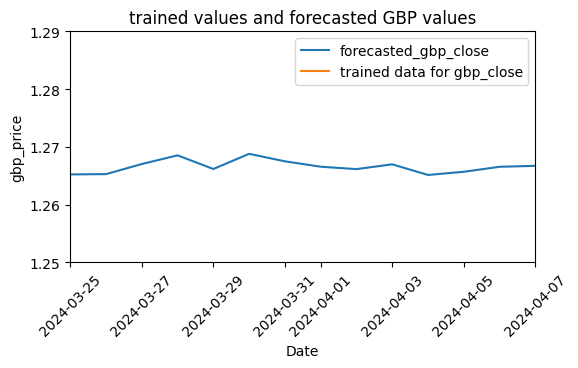

In [ ]:
#visulaisation of the forecasted output and the trained dataset in one chart for the trade decision
start_date= date_var
end_date= X_pred_df.index.max()
plt.figure(figsize=(6,3))
sns.lineplot(x='Date', y= 'fore_gbp_close', data=X_pred_df, label= 'forecasted_gbp_close')
sns.lineplot(x='Date',y='gbp_close', data=xgb_train_df2, label='trained data for gbp_close' )
xmin=pd.to_datetime(start_date)
xmax= pd.to_datetime(end_date)
plt.ylim(1.25, 1.29)
plt.xlim(xmin,xmax)
plt.xlabel('Date')
plt.ylabel('gbp_price')
plt.title('trained values and forecasted GBP values')
plt.xticks(rotation=45)
plt.legend()
plt.show()